Models based on single trees or rules, however, do have particular weaknesses. Two well-known weaknesses are
- (1) model instability (i.e., slight changes in the data can drastically change the structure of the tree or rules and, hence, the interpretation) and
- (2) less-than-optimal predictive performance. 

Basic Regression Trees
- The predictor to split on and value of the split
- The depth or complexity of the tree
- The prediction equation in the terminal nodes

>Tree models intrinsically conduct feature selection; if a predictor is never used in a split, the prediction equation is independent of these data. This advantage is weakened when there are highly correlated predictors. If two predictors are extremely correlated, the choice of which to use in a split is somewhat random. 

In [1]:
#data
library(AppliedPredictiveModeling)
data(solubility)
ls(pattern="^solT") 

[1] "solTestX"       "solTestXtrans"  "solTestY"       "solTrainX"     
[5] "solTrainXtrans" "solTrainY"

In [4]:
#data
library(AppliedPredictiveModeling)
library(caret)

data(solubility)
trn <- solTrainX[,-findCorrelation(cor(solTrainX))]
vld <- solTestX[,-findCorrelation(cor(solTestX))]

\begin{remark}
To tune an CART tree over the complexity parameter, the method option in the train function should be set to method = "rpart". To tune over maximum depth, the method option should be set to method="rpart2"
\end{remark}


In [9]:
#single trees
fit_tree <- train(solTrainXtrans,solTrainY,method = "rpart2",
                 tuneLength=10,trControl=trainControl(method = "cv"))
fit_tree$results

maxdepth RMSE     Rsquared  MAE       RMSESD     RsquaredSD MAESD     
1   1       1.618610 0.3773936 1.2669221 0.12326704 0.05339085 0.11281269
2   2       1.433576 0.5050966 1.1333276 0.07896175 0.06740885 0.08398218
3   3       1.367012 0.5523346 1.0861536 0.08028157 0.06470701 0.07371673
4   4       1.262942 0.6182750 1.0085447 0.06973353 0.05534989 0.05844988
5   5       1.189582 0.6620358 0.9389860 0.05587609 0.04854973 0.05097687
6   6       1.139669 0.6866121 0.8986752 0.04949088 0.05524242 0.04461994
7   7       1.115016 0.7000287 0.8776503 0.05475764 0.05450043 0.04390446
8   8       1.086087 0.7161991 0.8480972 0.06524938 0.05488511 0.04433096
9   9       1.089323 0.7147209 0.8458780 0.06097842 0.05049405 0.04385528
10 10       1.053258 0.7338582 0.8135962 0.07212172 0.04783307 0.04795181

\begin{remark}
To tune a conditional inference tree over mincriterion, the method option in the train function should be set to method = "ctree". To tune over maximum depth, the method option should be set to method="ctree2".
\end{remark}


In [14]:
fit_ctree <- train(solTrainXtrans,solTrainY,method = "ctree2",
                 tuneLength=10,trControl=trainControl(method = "cv"))

In [22]:
fit_ctree$bestTune

maxdepth mincriterion
91 10       0.01

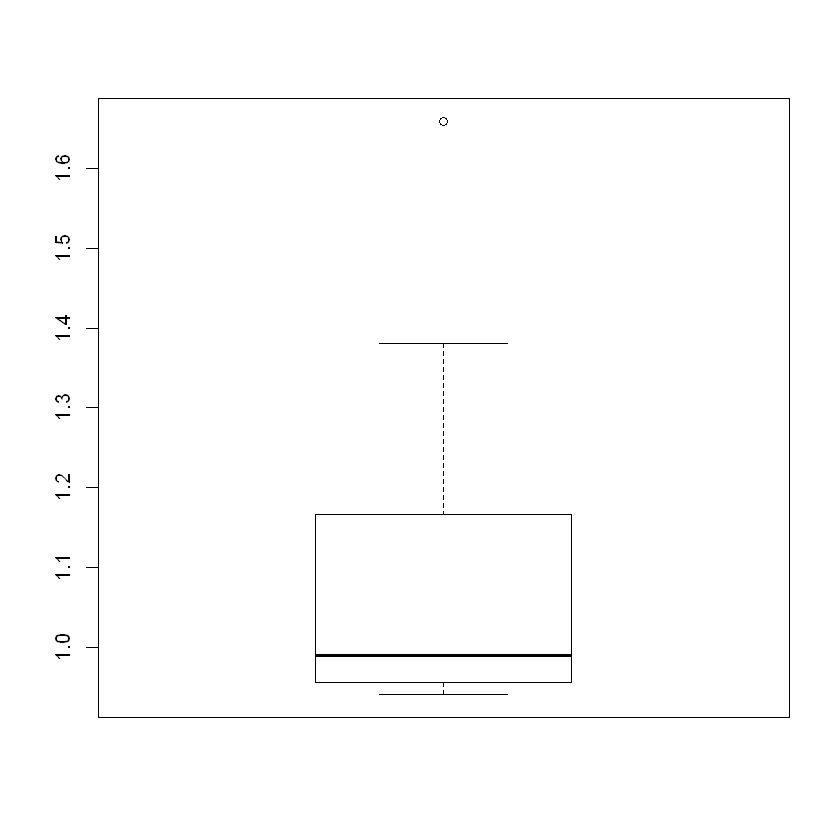

In [23]:
boxplot(fit_ctree$results$RMSE)

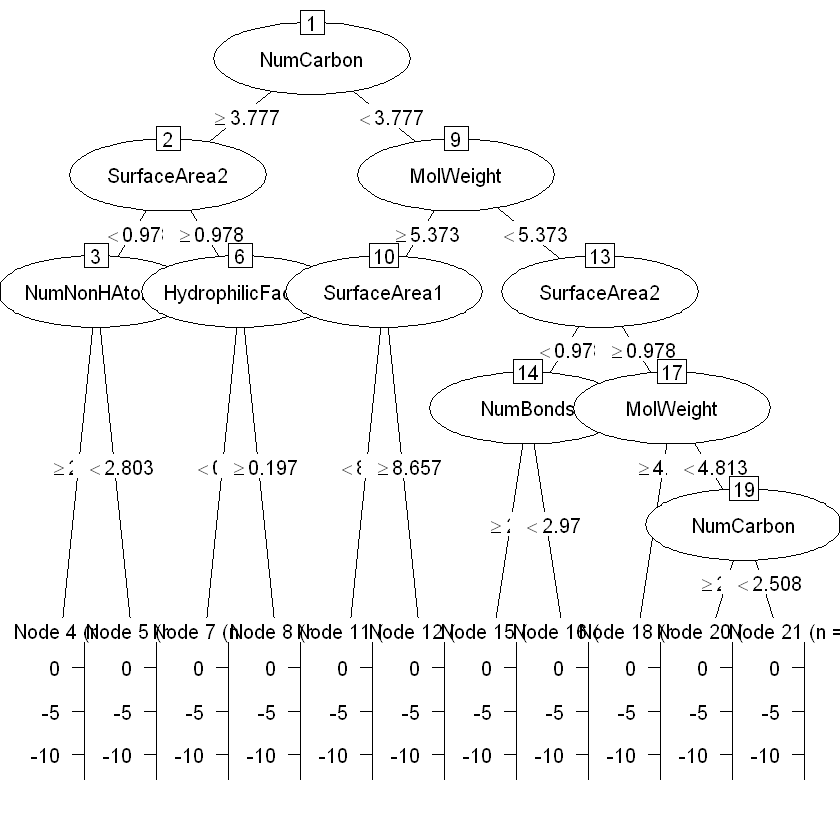

In [19]:
library(partykit)
library(party)
library(rpart)
df <- cbind(solTrainXtrans,solTrainY)
fit_tree <- rpart(solTrainY~.,data = df)
plot(as.party(fit_tree))
#http://rstatistics.net/decision-trees-with-r/

#http://rstatistics.net/variable-importance-of-predictors-that-contribute-most-significantly-to-a-response-variable-in-r/

Regression Model Tree

> the same problem, although not as severe as with a single tree. One approach to dealing with this issue is to use a different estimator in the terminal nodes. Here we focus on the model tree approach described in Quinlan (1992) called M5, which is similar to regression trees except:

- The splitting criterion is different.
- The terminal nodes predict the outcome using a linear model (as opposed to the simple average).
- When a sample is predicted, it is often a combination of the predictions from different models along the same path through the tree.

In [29]:
#model trees
library(RWeka)
set.seed(100)
# library(RWeka)
# fit_mtree <- M5P(solTrainY~.,data = df,control=Weka_control(M=10))
fit_mtree <- train(solTrainXtrans,solTrainY,method = "M5",
                  trControl=trainControl(method = "cv"),
                   control = Weka_control(M = 10))

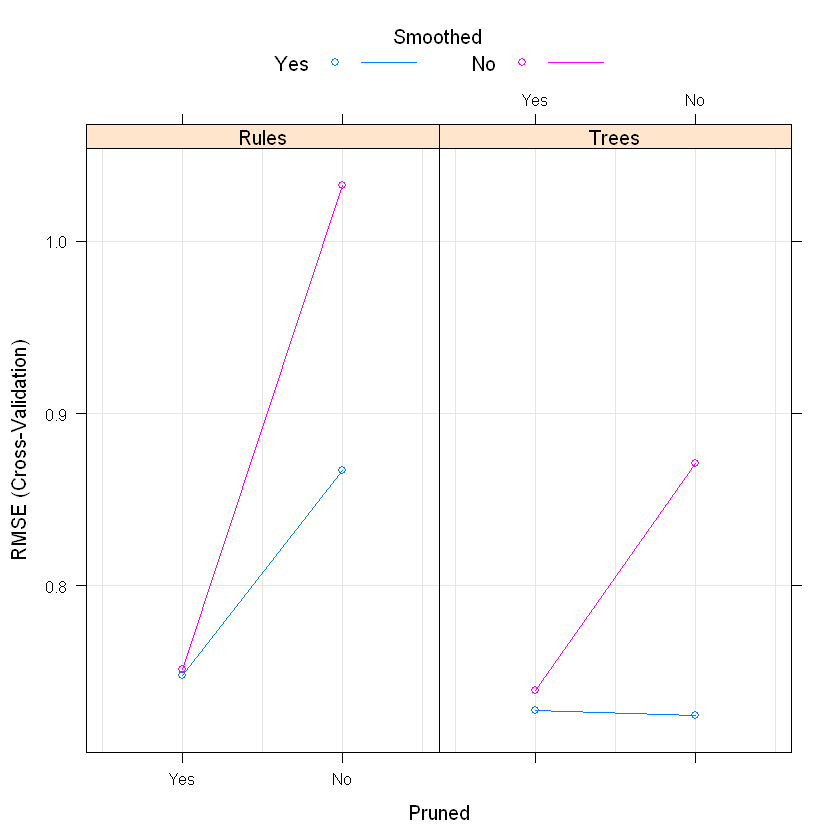

In [31]:
plot(fit_mtree)

In [32]:
fit_mtree$bestTune

pruned smoothed rules
6 No     Yes      No

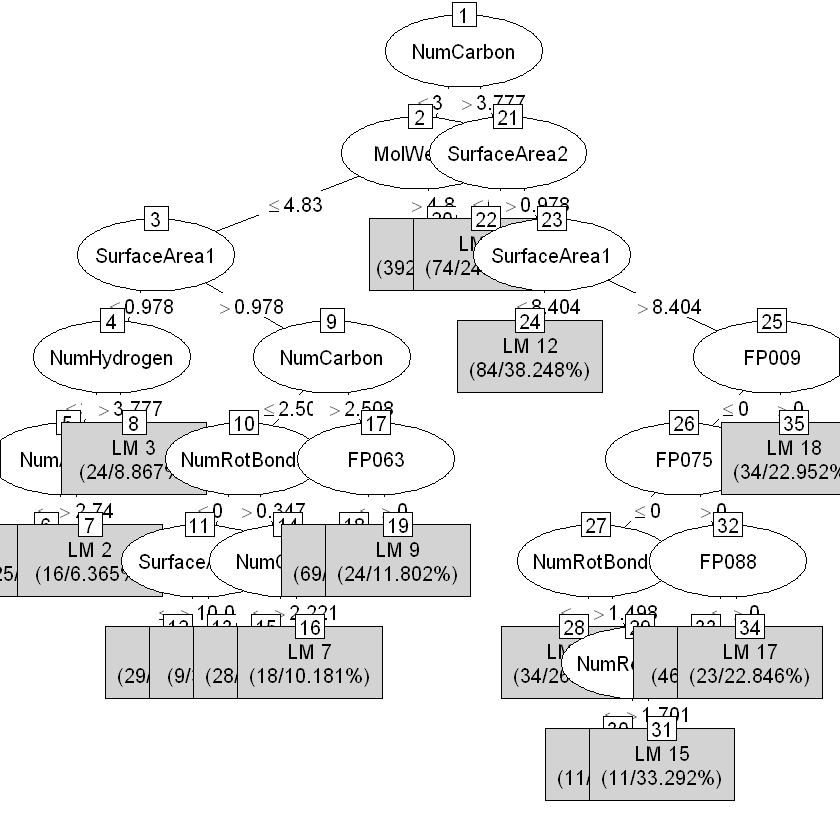

In [44]:
plot(fit_mtree)

In [3]:
# fit_rtree <- M5Rules(solTrainY~.,data = df)
# summary(fit_rtree)
set.seed(100)
fit_rtree <- train(solTrainXtrans,solTrainY,method = "M5Rules",
                  trControl=trainControl(method = "cv",number=3))

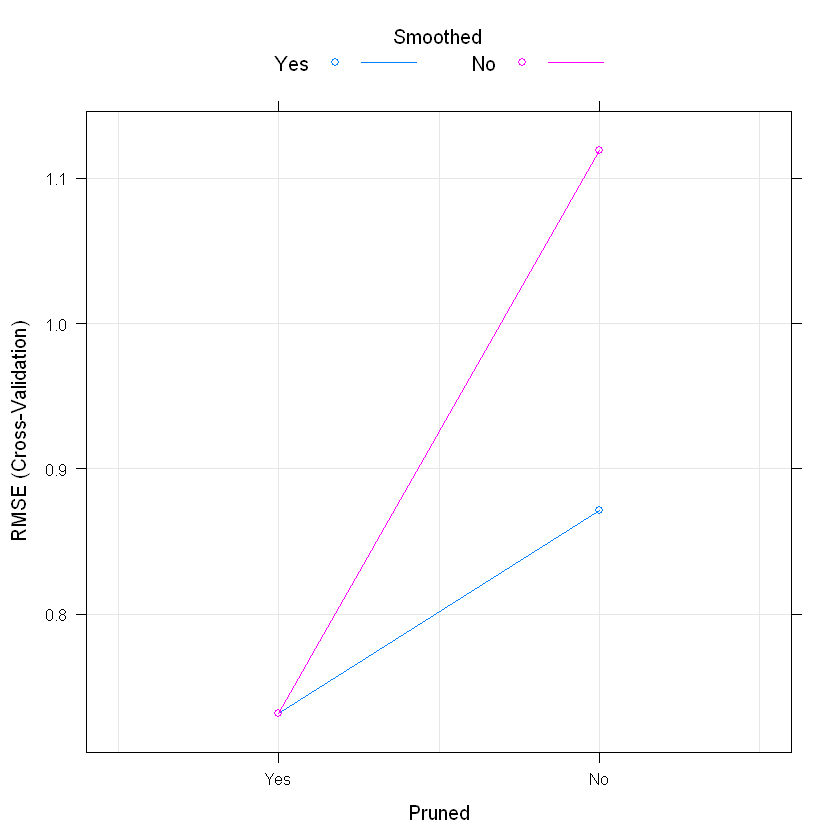

In [4]:
plot(fit_rtree)

In [6]:
fit_rtree$results

pruned smoothed RMSE      Rsquared  MAE       RMSESD     RsquaredSD 
1 Yes    Yes      0.7318775 0.8731118 0.5640544 0.08664484 0.009185247
2 Yes    No       0.7318775 0.8731118 0.5640544 0.08664484 0.009185247
3 No     Yes      0.8714670 0.8211761 0.6265014 0.06017128 0.012966834
4 No     No       1.1190916 0.7129676 0.8063540 0.11651258 0.025485595
  MAESD     
1 0.06069194
2 0.06069194
3 0.02426115
4 0.04911878

Bagged Tree
Although bagging usually improves predictive performance for unstable models, there are a few caveats. 
- First, computational costs and memory requirements increase as the number of bootstrap samples increases.
- Another disadvantage to this approach is that a bagged model is much less interpretable than a model that is not bagged.

In [6]:
#using ipred package
library(ipred)
# fit_BaggedTree <- ipredbagg(solTrainY,solTrainXtrans)
df <- cbind(solTrainXtrans,solTrainY)
fit_BaggedTree <- bagging(solTrainY~.,data=df)

In [10]:
#using party package
library(party)
df <- cbind(solTrainXtrans,solTrainY)
ctrl <- cforest_control(mtry=ncol(solTrainX))
fit_bagged <- cforest(solTrainY~.,data = df,controls = ctrl)
summary(fit_bagged)

In [2]:
#caret wrapper
library(caret)
library(ipred)
fit_treebag <- train(solTrainXtrans,solTrainY,method = "treebag",
                    trControl=trainControl(method = "cv",number=5))
fit_treebag

Loading required package: lattice
Loading required package: ggplot2


Bagged CART 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 761, 761, 759, 761, 762 
Resampling results:

  RMSE       Rsquared   MAE      
  0.9107243  0.8061015  0.6919636


In [5]:
fit_treebag$results

parameter RMSE      Rsquared  MAE       RMSESD     RsquaredSD MAESD     
1 none      0.9107243 0.8061015 0.6919636 0.07162046 0.03421537 0.07443517

Random Forest
> Random forests’ tuning parameter is the number of randomly selected predictors, k, to choose from at each split, and is commonly referred to as mtry. In the regression context, Breiman (2001) recommends setting mtry to be one-third of the number of predictors. For the purpose of tuning the mtry parameter, since random forests is computationally intensive, we suggest starting with five values of k that are somewhat evenly spaced across the range from 2 to P . 

> the default tuning parameter value for regression (mtry = P/3) tends to work well.

>  The practitioner must also specify the number of trees for the forest. Breiman (2001) proved that random forests is protected from overfitting; therefore, the model will not be adversely affected if a large number of trees are built for the forest. 

In [13]:
#rf based on cart
library(randomForest)
fit_rf <- randomForest(solTrainXtrans,solTrainY,importance = T,ntree=1000)
#rf based on conditional inference tree
library(party)
#cforest

In [15]:
head(importance(fit_rf))

%IncMSE  IncNodePurity
FP001 6.807316  1.712371    
FP002 7.472519  2.109143    
FP003 7.705398  2.510316    
FP004 8.008886 16.735312    
FP005 5.604884  1.499980    
FP006 6.220639  5.090895

In [21]:
library(caret)
fit_rf<- train(solTrainXtrans,solTrainY,method = "rf",
#                method = "cforest",
                    trControl=trainControl(method = "cv",number=5))
fit_rf$results

mtry RMSE      Rsquared  MAE       RMSESD     RsquaredSD MAESD     
1   2  1.0651931 0.8182107 0.8238175 0.03559180 0.04045972 0.03491924
2 115  0.6659069 0.8941867 0.4859293 0.07845253 0.02936434 0.04650931
3 228  0.6701072 0.8927388 0.4905756 0.07527986 0.02888717 0.04689330

Boosted Trees

In [24]:
library(gbm)
fit_gbm <- gbm.fit(solTrainXtrans,solTrainY,distribution = "gaussian")
fit_gbm

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        4.1814             nan     0.0010    0.0030
     2        4.1785             nan     0.0010    0.0031
     3        4.1753             nan     0.0010    0.0030
     4        4.1723             nan     0.0010    0.0030
     5        4.1691             nan     0.0010    0.0029
     6        4.1661             nan     0.0010    0.0031
     7        4.1627             nan     0.0010    0.0029
     8        4.1597             nan     0.0010    0.0030
     9        4.1563             nan     0.0010    0.0030
    10        4.1533             nan     0.0010    0.0029
    20        4.1227             nan     0.0010    0.0031
    40        4.0648             nan     0.0010    0.0027
    60        4.0066             nan     0.0010    0.0027
    80        3.9512             nan     0.0010    0.0026
   100        3.8978             nan     0.0010    0.0024



A gradient boosted model with gaussian loss function.
100 iterations were performed.
There were 228 predictors of which 3 had non-zero influence.

In [ ]:
grid_gbm <- expand.grid(interaction.depth=seq(1,7,by=2),
                       n.trees=seq(100,1000,by=50),n.minobsinnode=seq(1,20,by=2),
                       shrinkage=c(0.01,0.1))

set.seed(100)
fit_gbm <- train(solTrainXtrans,solTrainY,
                 method = "gbm",verbose=F,
                tuneGrid=grid_gbm
#                 ,trControl=trainControl(method = "cv",number=5)
                )

In [27]:
fit_gbm

Stochastic Gradient Boosting 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 760, 761, 763, 761, 759 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared   MAE      
  1                   50      1.0236157  0.7786639  0.7818669
  1                  100      0.8548815  0.8330803  0.6490165
  1                  150      0.7892336  0.8525187  0.6018894
  2                   50      0.8475227  0.8369742  0.6473716
  2                  100      0.7375561  0.8698542  0.5683573
  2                  150      0.6991342  0.8823330  0.5369285
  3                   50      0.7828552  0.8574353  0.6002521
  3                  100      0.6889702  0.8857376  0.5317244
  3                  150      0.6586615  0.8952871  0.5078962

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
RMSE was used to select the optim

Cubist

In [11]:
library(Cubist)
library(caret)
# fit_cubist <- cubist(solTrainXtrans,solTrainY)

#caret wraper
grid_cubist <- expand.grid(committees=seq(20,100,by=20),
                          neighbors=c(0,1,5,9))
fit_cubist <- train(solTrainXtrans,solTrainY,method="cubist",tuneGrid=grid_cubist)

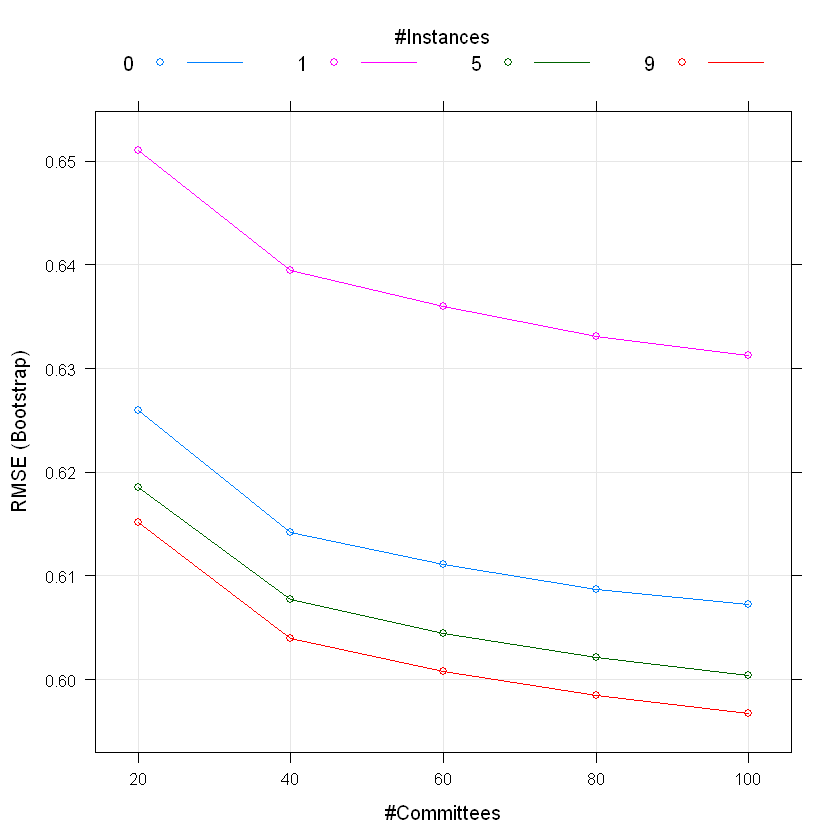

In [12]:
plot(fit_cubist)